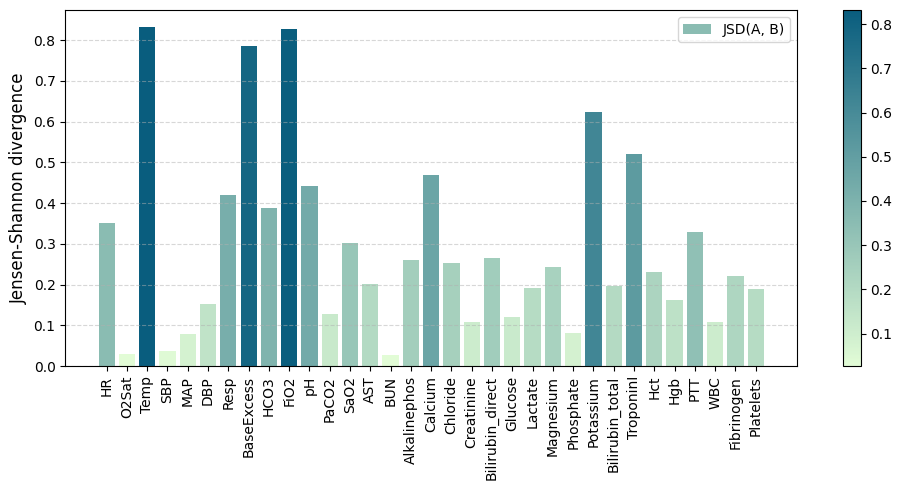

In [81]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jensenshannon
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Define paths
folder_a = "training_setA"
folder_b = "training_setB"

# Define relevant feature columns (indexes start from 0)
feature_columns = list(range(8)) + list(range(8, 34))

# Function to read all .psv files in a folder and extract relevant columns
def load_data(folder):
    data_frames = []
    for filename in os.listdir(folder):
        if filename.endswith(".psv"):
            file_path = os.path.join(folder, filename)
            df = pd.read_csv(file_path, sep='|')
            df = df.iloc[:, feature_columns]  # Select relevant columns
            data_frames.append(df)
    return pd.concat(data_frames, ignore_index=True)

# Load datasets
data_a = load_data(folder_a)
data_b = load_data(folder_b)

# Function to compute KDE-based probability distribution
def compute_kde_distribution(data, bw=0.5, num_points=100):
    prob_distributions = {}
    for column in data.columns:
        values = data[column].dropna()
        if values.empty:
            continue  # Skip if no data
        
        kde = gaussian_kde(values, bw_method=bw)
        x_grid = np.linspace(values.min(), values.max(), num_points)
        pdf = kde(x_grid)
        prob_distributions[column] = pdf / pdf.sum()  # Normalize
    return prob_distributions

# Compute KDE probability distributions for both sets
dist_a = compute_kde_distribution(data_a, bw=0.3)
dist_b = compute_kde_distribution(data_b, bw=0.3)

# Compute JSD for each feature
jsd_results = {}
for column in dist_a.keys():
    if column in dist_b:
        jsd_results[column] = jensenshannon(dist_a[column], dist_b[column])

# Convert results to DataFrame
jsd_df = pd.DataFrame(jsd_results.items(), columns=["Feature", "JSD"])

# Define gradient colors
cmap = mcolors.LinearSegmentedColormap.from_list("custom_gradient", ["#e2fcd6", "#095d7e"])

# Normalize values to map to the colormap
norm = plt.Normalize(jsd_df["JSD"].min(), jsd_df["JSD"].max())
colors = [cmap(norm(value)) for value in jsd_df["JSD"]]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(jsd_df["Feature"], jsd_df["JSD"], color=colors, label="JSD(A, B)")

# Add color bar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy array for color bar
cbar = plt.colorbar(sm, ax=ax)

# Formatting the plot
plt.xticks(rotation=90, fontsize=10)  # Rotate labels for readability
plt.yticks(fontsize=10)
plt.ylabel("Jensen-Shannon divergence", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle="--", alpha=0.5)

# Save and Show
plt.tight_layout()
plt.savefig("jsd_kde_plot.png", dpi=300)
plt.show()

### JSD used in machine learning model evaluation instead of KL divergence, where it provides a more stable comparison between distributions and is symmetric  

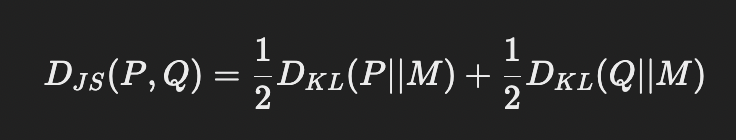

In [63]:
import os
import pandas as pd
from tabulate import tabulate  # For pretty table output in console
from IPython.display import display  # For Jupyter Notebook

# Define Paths for Hospital Data
folder_a = "training_setA"
folder_b = "training_setB"

def load_data(folder):
    """Load data from .psv files in a specified folder."""
    data_frames = []
    patient_ids = []
    
    for filename in os.listdir(folder):
        if filename.endswith(".psv"):
            file_path = os.path.join(folder, filename)
            df = pd.read_csv(file_path, sep='|')
            df["patient_id"] = filename.split(".")[0]  # Extract patient ID from filename
            data_frames.append(df)
            patient_ids.append(df["patient_id"].iloc[0])  # Unique patient ID
    
    combined_df = pd.concat(data_frames, ignore_index=True)
    return combined_df, len(patient_ids)

# Load Data for Hospital A and B
df_a, total_patients_a = load_data(folder_a)
df_b, total_patients_b = load_data(folder_b)

# Compute Summary Statistics
summary = {
    "Characteristic": ["Total Patients", "Septic Patients", "Sepsis Rate (%)", "Total Observations",
                        "Median ICU Stay (hours)", "Sepsis Onset Time (avg hours)", "Data Completeness (%)"],
    "Hospital A": [
        total_patients_a,
        df_a.groupby("patient_id")["SepsisLabel"].max().sum(),  # Patients who had sepsis
        df_a.groupby("patient_id")["SepsisLabel"].max().mean() * 100,
        len(df_a),
        df_a.groupby("patient_id")["ICULOS"].max().median(),
        df_a[df_a["SepsisLabel"] == 1].groupby("patient_id")["ICULOS"].min().mean(),
        df_a.notnull().mean().mean() * 100
    ],
    "Hospital B": [
        total_patients_b,
        df_b.groupby("patient_id")["SepsisLabel"].max().sum(),
        df_b.groupby("patient_id")["SepsisLabel"].max().mean() * 100,
        len(df_b),
        df_b.groupby("patient_id")["ICULOS"].max().median(),
        df_b[df_b["SepsisLabel"] == 1].groupby("patient_id")["ICULOS"].min().mean(),
        df_b.notnull().mean().mean() * 100
    ]
}

# Convert to DataFrame
summary_df = pd.DataFrame(summary)

# Compute Combined and Difference Columns
summary_df["Combined"] = summary_df["Hospital A"] + summary_df["Hospital B"]
summary_df.loc[summary_df["Characteristic"].isin(["Sepsis Rate (%)", "Median ICU Stay (hours)", "Sepsis Onset Time (avg hours)", "Data Completeness (%)"]), "Combined"] = \
    summary_df.loc[summary_df["Characteristic"].isin(["Sepsis Rate (%)", "Median ICU Stay (hours)", "Sepsis Onset Time (avg hours)", "Data Completeness (%)"]), ["Hospital A", "Hospital B"]].mean(axis=1)

# Formatting: Integers where applicable, otherwise 2 decimal places
summary_df.iloc[:, 1:] = summary_df.iloc[:, 1:].applymap(lambda x: f"{int(x)}" if x == int(x) else f"{x:.2f}")

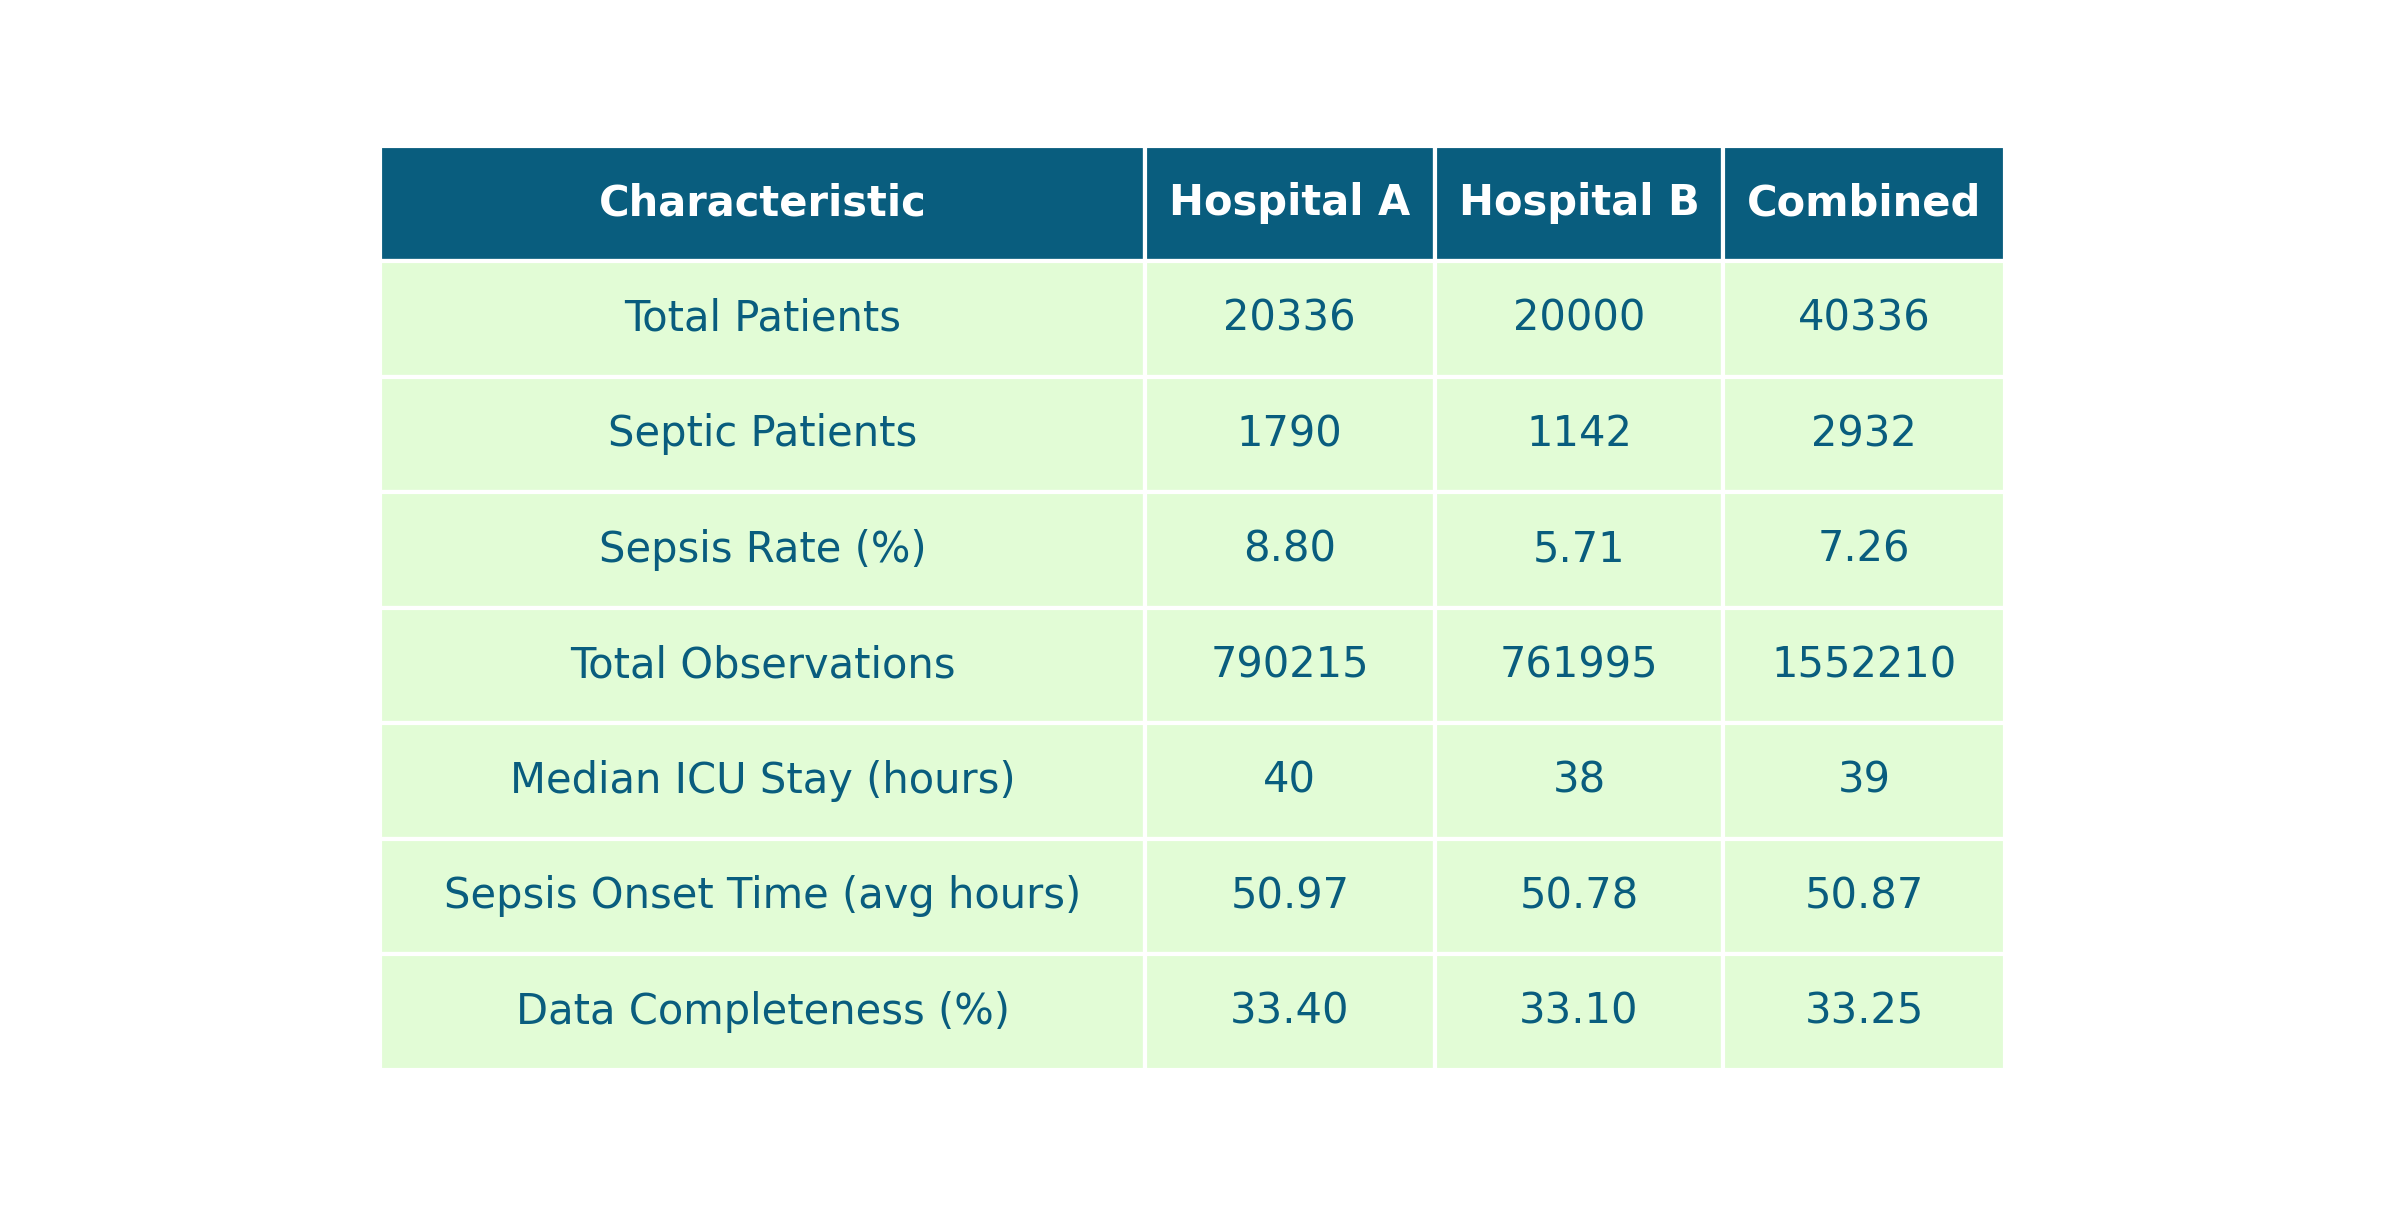

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image

# Define color scheme
bg_color = "#e2fcd6"  # Light green background
text_color = "#095d7e"  # Dark blue text

def save_table_as_png(df, filename="summary_table.png"):
    """Save pandas DataFrame as a styled table in a PNG file and display it in Jupyter Notebook."""
    fig, ax = plt.subplots(figsize=(10, 5))  # Increase figure height for more spacing
    ax.axis('tight')
    ax.axis('off')
    
    # Create the table
    table = ax.table(cellText=df.values, 
                     colLabels=df.columns, 
                     cellLoc='center', 
                     loc='center')

    # Apply color formatting
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width([i for i in range(len(df.columns))])  # Auto adjust width
    
    # Set background, text colors, and row height
    for (i, j), cell in table.get_celld().items():
        cell.set_edgecolor("white")
        cell.set_height(0.1)  # Increase row height
        
        if i == 0:  # Header row
            cell.set_facecolor(text_color)
            cell.set_text_props(color="white", weight="bold")
        else:  # Data rows
            cell.set_facecolor(bg_color)
            cell.set_text_props(color=text_color)
    
    # Save as PNG
    plt.savefig(filename, bbox_inches="tight", dpi=300)
    plt.close()

    # Display the saved image in the notebook
    display(Image(filename))

# Call function to save and display table
save_table_as_png(summary_df, "summary_table.png")